In [21]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import re

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [17]:
data_path = "/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/raw/"
exp_stage = "final"
task = "shared_control"

pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
data_files = glob.glob(pattern)

In [18]:
def string_to_numbers(string_data):
    if isinstance(string_data, float):  # Check if the input is already a float
        return [string_data]  # If it's a float, return it as a list
    string_data = string_data.strip("'")  # Remove leading and trailing single quotes
    numbers = [float(num) for num in string_data.split()]
    return numbers

In [19]:
def get_subject_label(file):
    """
    Extract the subject label from a given file path.

    Parameters:
    - file (str): The file path from which to extract the subject label.

    Returns:
    - str or None: The extracted subject label (e.g., 's001') if found, 
                   otherwise returns None and prints a message.
    """
    
    match = re.search(r'/sub-(s\d{3})/', file)
    
    if match:
        subject_label = match.group(1)
        print("Subject label:", subject_label)
        return subject_label
    else:
        print("No subject label found.")
        return None

In [13]:
def process_trial_data(data):
    trial_results = {}
    ssrt_list = []

    for idx, row in data.iterrows():
        trial_number = idx
        stop_onset = row['SSD_mean']    
        time_stamps = row['time_stamps_raw']
        closest_time = min(time_stamps, key=lambda x: abs(x - stop_onset))
        index_of_closest = time_stamps.index(closest_time)
        raw_pressure = row['pressures_raw'][index_of_closest]

        trial_results[trial_number] = {
            'stop_onset': stop_onset,
            'closest_time': closest_time,
            'index_of_closest': index_of_closest,
            'raw_pressure': raw_pressure,
            'distances_raw': row['distances_raw'],
            'pressures_raw': row['pressures_raw'],
            'time_stamps_raw': row['time_stamps_raw'],
            'condition': row['condition']
        }

    for trial_number, trial_data in trial_results.items():
        index_of_closest = trial_data['index_of_closest']
        pressures_raw = trial_data['pressures_raw']
        time_stamps_raw = trial_data['time_stamps_raw']

        found_stop_pressure = None
        stop_moment = None
        for i in range(index_of_closest + 1, len(pressures_raw)):
            if pressures_raw[i] == 0:
                found_stop_pressure = pressures_raw[i]
                stop_moment = time_stamps_raw[i]
                break

        lower_pressure_timestamp = None
        index_of_inhibition = None
        if found_stop_pressure is not None:
            for i in range(index_of_closest + 1, len(pressures_raw)):
                if pressures_raw[i] < pressures_raw[index_of_closest]:
                    lower_pressure_timestamp = time_stamps_raw[i]
                    index_of_inhibition = i
                    break

        trial_data['stop_pressure'] = found_stop_pressure
        trial_data['stop_moment'] = stop_moment
        trial_data['moment_of_inhibition'] = lower_pressure_timestamp
        trial_data['index_of_inhibition'] = index_of_inhibition

        moment_of_inhibition = trial_data['moment_of_inhibition']

        if stop_onset is not None and moment_of_inhibition is not None:
            trial_data['ssrt'] = moment_of_inhibition - trial_data['stop_onset'] 
            ssrt = moment_of_inhibition - trial_data['stop_onset'] 
            ssrt_list.append(ssrt)
        else:
            ssrt_list.append(np.nan)
            trial_data['ssrt'] = np.nan

    return trial_results, ssrt_list

# plotting histogram of moments of inhibition

In [22]:
data = {}
for file in data_files:
    subject = get_subject_label(file)
    df = pd.read_csv(file)
    df['phase_raw'] = df['phase_raw'].str.strip("'")
    df['block_raw'] = df['block_raw'].str.strip("'")

    df_test = df.query("phase_raw == 'test'")
    block_1 = df_test.query("block_raw == 'block 1'")
    block_2 = df_test.query("block_raw == 'block 2'")
    block_1 = block_1.reset_index(drop=True)
    block_2 = block_2.reset_index(drop=True)

    task_dfs = [block_1, block_2]

    for df in task_dfs:
        if 'ai' in df['condition'].values:
            ai_data = df.copy()
            ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
            ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
            ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
        else:
            control_data = df.copy()
            control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
            control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
            control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)

    data[subject] = {'ai': {'data': ai_data}, 'control': {'data': control_data}}

    for block in data[subject].keys():
        trial_results, ssrt_list = process_trial_data(data[subject][block]['data'])
        data[subject][block]['trial_results'] = trial_results
        data[subject][block]['ssrt_list'] = ssrt_list  

Subject label: s042
Subject label: s029
Subject label: s016
Subject label: s011
Subject label: s018
Subject label: s027
Subject label: s020
Subject label: s043
Subject label: s021
Subject label: s019
Subject label: s026
Subject label: s010
Subject label: s028
Subject label: s017
Subject label: s035
Subject label: s032
Subject label: s004
Subject label: s005
Subject label: s033
Subject label: s034
Subject label: s012
Subject label: s015
Subject label: s023
Subject label: s024
Subject label: s041
Subject label: s025
Subject label: s022
Subject label: s014
Subject label: s013
Subject label: s040
Subject label: s031
Subject label: s036
Subject label: s009
Subject label: s007
Subject label: s038
Subject label: s006
Subject label: s039
Subject label: s037
Subject label: s008
Subject label: s030


In [23]:
master_ssrt = [
    ssrt
    for subject in data.keys()
    for ssrt in data[subject]['control']['ssrt_list']
]

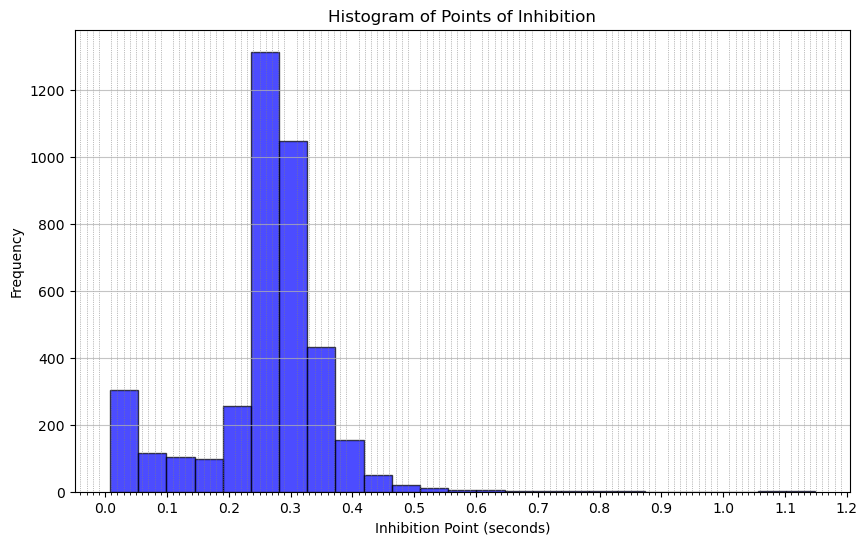

In [24]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(master_ssrt, bins=25, color='blue', edgecolor='black', alpha=0.7)

# Labeling the axes and the plot
plt.xlabel('Inhibition Point (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Points of Inhibition')

# Setting x-axis major and minor ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))  # Major ticks at every 0.1 seconds
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.01))  # Minor ticks at every 0.01 seconds

# Show grid and the plot
plt.grid(axis='y', alpha=0.75)
plt.grid(which='minor', axis='x', linestyle=':', linewidth='0.5', color='gray')  # Minor grid lines

plt.show()

Subject label: s042
Subject label: s029
Subject label: s016
Subject label: s011
Subject label: s018
Subject label: s027
Subject label: s020
Subject label: s043
Subject label: s021
Subject label: s019
Subject label: s026
Subject label: s010
Subject label: s028
Subject label: s017
Subject label: s035
Subject label: s032
Subject label: s004
Subject label: s005
Subject label: s033
Subject label: s034
Subject label: s012
Subject label: s015
Subject label: s023
Subject label: s024
Subject label: s041
Subject label: s025
Subject label: s022
Subject label: s014
Subject label: s013
Subject label: s040
Subject label: s031
Subject label: s036
Subject label: s009
Subject label: s007
Subject label: s038
Subject label: s006
Subject label: s039


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Subject label: s037
Subject label: s008
Subject label: s030


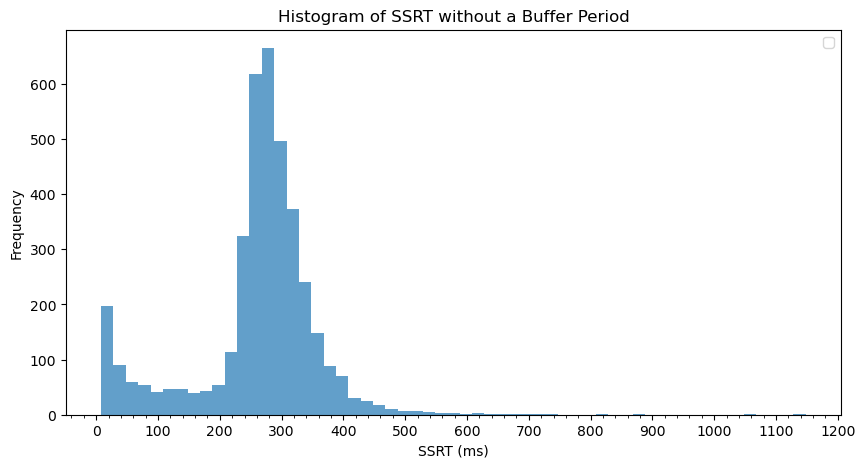

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


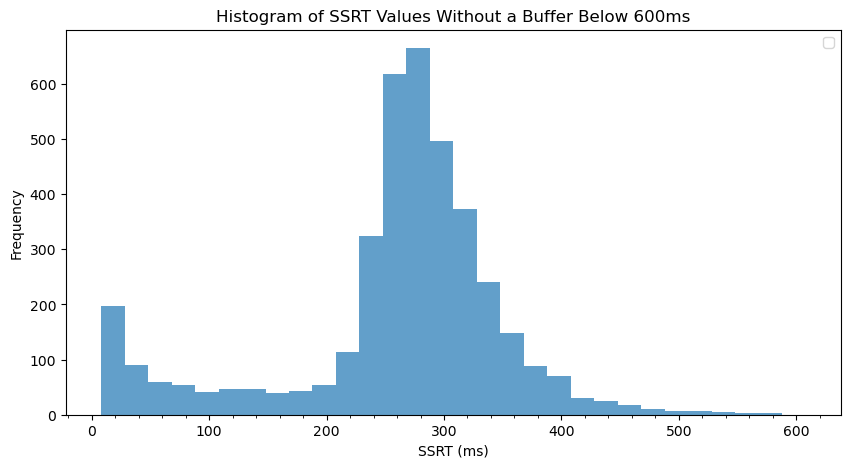

In [41]:
all_data = []
for file in data_files:
    subject = get_subject_label(file)
    df = pd.read_csv(file)
    trial_results = data[subject]['control']['trial_results']
    for trial in trial_results.values():
        ssrt = trial['ssrt']
        stop_onset = trial['stop_onset']
        all_data.append({'subject': subject, 'ssrt': ssrt, 'stop_onset': stop_onset})

# Create DataFrame
df = pd.DataFrame(all_data)

# Median split based on stop_onset
median_ssd = df['stop_onset'].median()
low_ssd = df[df['stop_onset'] <= median_ssd]
high_ssd = df[df['stop_onset'] > median_ssd]

# Assume 'df' is your existing DataFrame with SSRT values in seconds
# Define bin edges for 20 ms intervals
min_ssrt = df['ssrt'].min() * 1000  # Convert to milliseconds
max_ssrt = df['ssrt'].max() * 1000  # Convert to milliseconds
bin_edges = np.arange(min_ssrt, max_ssrt + 20, 20)  # Create bins of size 20 ms

# Create histogram of SSRT for the full dataset
plt.figure(figsize=(10, 5))
plt.hist(df['ssrt'] * 1000, bins=bin_edges, alpha=0.7)  # Convert to milliseconds for the histogram
plt.xlabel('SSRT (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of SSRT without a Buffer Period')
plt.legend()
plt.gca().xaxis.set_major_locator(MultipleLocator(100))  # Major ticks every 100 ms
plt.gca().xaxis.set_minor_locator(MultipleLocator(20))  # Minor ticks every 20 ms
plt.savefig('figures/ssrt_without_buffer_histogram.png')
plt.show()

# Create a second histogram for SSRT values below 0.6 seconds
plt.figure(figsize=(10, 5))
df_below_06 = df[df['ssrt'] <= 0.6]  # Filter for values below or equal to 0.6 seconds
plt.hist(df_below_06['ssrt'] * 1000, bins=np.arange(min_ssrt, 600 + 20, 20), alpha=0.7)  # Convert to milliseconds for the histogram
plt.xlabel('SSRT (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of SSRT Values Without a Buffer Below 600ms')
plt.legend()
plt.gca().xaxis.set_major_locator(MultipleLocator(100))  # Major ticks every 100 ms
plt.gca().xaxis.set_minor_locator(MultipleLocator(20))  # Minor ticks every 20 ms
plt.savefig('figures/ssrt_without_buffer_zoomed_in_histogram.png')
plt.show()

# Create histograms for median split groups
# plt.figure(figsize=(10, 5))
# plt.hist(low_ssd['ssrt'], bins=bin_edges, alpha=0.7, label='Low SSD')
# plt.hist(high_ssd['ssrt'], bins=bin_edges, alpha=0.7, label='High SSD')
# plt.xlabel('SSRT')
# plt.ylabel('Frequency')
# plt.title('Histogram of SSRT by Median Split of SSD')
# plt.legend()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))  # Major ticks at every 0.1 seconds
# plt.gca().xaxis.set_minor_locator(MultipleLocator(0.01))  # Minor ticks at every 0.01 seconds
# plt.savefig('histogram_ssd_split.png')
# plt.show()

In [ ]:
filtered_df = df[(df['ssrt'] >= 0.0) & (df['ssrt'] <= 0.07)]
ssds_in_range = filtered_df['stop_onset']
(ssds_in_range)


7      2.530509
8      2.452799
9      2.620541
10     2.293023
45     2.372725
53     4.054217
107    3.460214
141    2.552186
153    2.717387
157    3.980720
194    2.294829
217    2.037470
235    3.089356
265    2.153767
282    2.111591
Name: stop_onset, dtype: float64

# Comparing ai stop with non ai stop

In [ ]:
data.keys()

dict_keys(['s1', 's2', 's3'])

In [ ]:
data['s1'].keys()

dict_keys(['ai', 'control'])

In [ ]:
data['s1']['ai'].keys()

dict_keys(['data', 'trial_results', 'ssrt_list'])

In [ ]:
data['s1']['ai']['trial_results'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
data['s1']['ai']['trial_results'][0].keys()

dict_keys(['stop_onset', 'closest_time', 'index_of_closest', 'raw_pressure', 'distances_raw', 'pressures_raw', 'time_stamps_raw', 'condition', 'stop_pressure', 'stop_moment', 'moment_of_inhibition', 'index_of_inhibition', 'ssrt'])

In [ ]:
stop_comparison_data = {}
for subject in data.keys():
    stop_comparison_data[subject] = {}
    for condition in data[subject].keys():
        
        stop_comparison_data[subject][condition] = {}
        
        moments_of_inhibition = []
        ssrts = []
        stop_moments = []
        
        for trial in data[subject][condition]['trial_results'].keys():
            
            if data[subject][condition]['trial_results'][trial]['condition'] == 'stop':
                moments_of_inhibition.append(data[subject][condition]['trial_results'][trial]['moment_of_inhibition'])
                ssrts.append(data[subject][condition]['trial_results'][trial]['ssrt'])
                stop_moments.append(data[subject][condition]['trial_results'][trial]['stop_moment'])

        
            
        stop_comparison_data[subject][condition]['moments_of_inhibition'] = [x if x is not None else np.nan for x in moments_of_inhibition]
        stop_comparison_data[subject][condition]['ssrts'] = [x if x is not None else np.nan for x in ssrts]
        stop_comparison_data[subject][condition]['stop_moments'] = [x if x is not None else np.nan for x in stop_moments]

In [ ]:
np.nanmean(stop_comparison_data['s1']['ai']['moments_of_inhibition'])

3.3370198246091602

In [ ]:
np.nanmean(stop_comparison_data['s1']['control']['moments_of_inhibition'])

3.0597388359783877

In [ ]:
len(stop_comparison_data['s1']['ai']['moments_of_inhibition'])

10

In [ ]:
np.nanmean(stop_comparison_data['s2']['ai']['moments_of_inhibition'])

3.1284891720861197

In [ ]:
np.nanmean(stop_comparison_data['s2']['control']['moments_of_inhibition'])

3.1076361581529537

In [ ]:
np.nanmean(stop_comparison_data['s3']['ai']['moments_of_inhibition'])

3.0486037869006397

In [ ]:
np.nanmean(stop_comparison_data['s3']['control']['moments_of_inhibition'])

3.153039333592985